## Task 4.  Algorithms of unconditional nonlinear optimization. Stochastic and metaheuristic algorithms

### Generate noisy data {$x_k, y_k$}, where $k = 0, 1, .. 10^{3}$, according to the rule: 

\begin{equation*}
    \\
    x_k = \frac{3k}{10^{3}},
    \; \; \;
    y_k =
    \begin{cases}
        \: -10^{2} + \delta_{k}, \; f(x_{k}) < -10^{2}
        \\
        \\
        \: f(x_{k}) + \delta_{k}, \; |f(x_{k})| \leq 10^{2},
        \\
        \\
        \: 10^{2} + \delta_{k}, \; f(x_{k}) > 10^{2}
    \end{cases}
    \; \;
    f(x) = \frac{1}{x^{2} - 3x + 2}
\end{equation*}

### where $\delta_k \sim N(0, 1)$ are values of a random variable with standard normal distribution. Approximate the data by the following rational function:

\begin{equation*}
    F(x, a, b, c, d) = \frac{ax + b}{x^{2} + cx + d}
\end{equation*}

### by means of least squares through the numerical minimization of the following function:

\begin{equation*}
    D(a, b, c, d) = \sum_{k = 0}^{1000}{(F(x_k, a, b, c, d) - y_k)^2}
\end{equation*}

### To solve the minimization problem, use the Nelder Mead algorithm, the Levenberg-Marquardt algorithm, and at least one of the methods:simulated annealing, differential evolution, or the particle swarm method. If necessary, specify the initial approximations and other parameters of the methods. No more than 1000 iterations are allowed in each method. 

### Visualize the data and approximating curves obtained by several numerical optimization methods on a single graph. Calculate the sum of squared deviations for each method. Analyze the obtained results in terms of the number of iterations performed and the values of the sums of squared deviations.

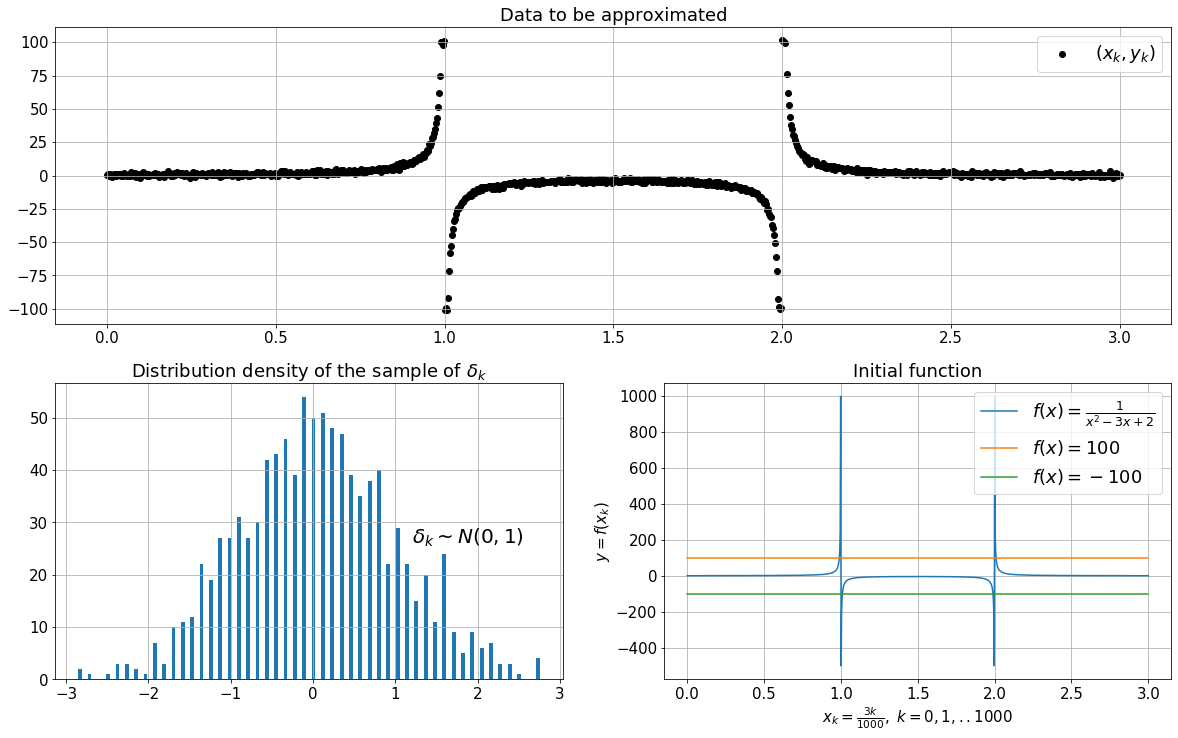

In [221]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar

global x_arr
global y_arr

# Data generation part:

def initial_func(x):
    return 1 / (x ** 2 - 3 * x + 2)

np.random.seed(4)
el_num = 1001
mu, sigma = 0, 1
delta_arr = np.random.normal(mu, sigma, el_num)

x_arr = np.linspace(0, 3, el_num)
y_arr = np.array([(lambda y: - 100 if (y < -100) else (100 if (y > 100) else y))(initial_func(x_arr[k])) \
                  +  delta_arr[k] for k in range(el_num)])

mpl.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize = (20, 12))
plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

plt.subplot(2, 2, 3)
plt.hist(delta_arr, bins = 50, rwidth = 0.4)
plt.text(x = 1.2, y = 26, s = r'$\delta_k \sim N(0, 1)$', fontsize = 20)
plt.title('Distribution density of the sample of $\delta_k$')
plt.grid()

plt.subplot(2, 2, 4)
x_arr = np.linspace(0, 3, el_num)
plt.plot(x_arr, initial_func(x_arr), x_arr, [100] * el_num, x_arr, [-100] * el_num)
plt.title('Initial function')
plt.legend([r'$f(x) = \frac{1}{x^2 - 3x + 2}$', r'$f(x) = 100$', r'$f(x) = -100$'], loc = 'best', fontsize = 18)
plt.xlabel(r'$x_k = \frac{3k}{1000}, \; k = 0, 1, .. 1000$')
plt.ylabel(r'$y = f(x_k)$')
plt.grid()

plt.subplot(2, 1, 1)
plt.scatter(x_arr, y_arr, c = 'k')
plt.title('Data to be approximated')
plt.legend([r'$(x_k, y_k)$'], loc = 'best', fontsize = 18)
plt.grid()
plt.show()

fig.savefig('initial_distribution.png')

In [214]:
# Working part:

def approx_func(x, args):
    return (args[0] * x + args[1]) / (x ** 2 + args[2] * x + args[3])


def least_squares_func(args):
    return np.sum(np.square((args[0] * x_arr + args[1]) / (x_arr ** 2 + args[2] * x_arr + args[3]) - y_arr))


def gradient_num(func, args, eps = 1e-5):
    
    '''each time the gradient is calculated, the function is evaluated for 8 times'''
    
    a, b, c, d = args[:]
    
    part_deriv_a = (func([a + eps, b, c, d]) - func([a - eps, b, c, d])) / (2 * eps)
    part_deriv_b = (func([a, b + eps, c, d]) - func([a, b - eps, c, d])) / (2 * eps)
    part_deriv_c = (func([a, b, c + eps, d]) - func([a, b, c - eps, d])) / (2 * eps)
    part_deriv_d = (func([a, b, c, d + eps]) - func([a, b, c, d - eps])) / (2 * eps)
    
    return np.array([part_deriv_a,  part_deriv_b, part_deriv_c, part_deriv_d])


def Nelder_Mead(initial_approx = np.ones(4), eps = 1e-5):
    
    res = minimize(least_squares_func, initial_approx, method = 'nelder-mead', options = {'xatol': eps, 'maxiter' : 1000})
    
    n_digits = abs(int(round(np.log10(eps))))
    params = [round(res.x[i], n_digits) for i in range(4)]
    
    return np.array(params[:] + [res.nit, least_squares_func(params)])
    

def Levenberg_Marquardt(initial_approx = np.ones(4), eps = 1e-5):
        
    reg_param = 0.1
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
        
    jac = np.array([gradient_num(lambda args: approx_func(x_i, args), args_prev) for x_i in x_arr])
    inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(4))
        
    delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_func(x_i, args_prev) for x_i in x_arr])))
    args_curr = args_prev + delta_arg
    
    func_eval_num += 8
    iter_num += 1
    
    while np.linalg.norm(args_curr - args_prev, np.inf) >= eps:
        
        args_prev = args_curr[:]
        
        jac = np.array([gradient_num(lambda args: approx_func(x_i, args), args_prev)for x_i in x_arr])
        inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(4))
        delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_func(x_i, args_prev) for x_i in x_arr])))
        
        args_curr = args_prev + delta_arg
        
        func_eval_num += 8
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))
    params = [round(args_curr[i], n_digits) for i in range(4)]
    
    return np.array(params[:] + [iter_num, least_squares_func(params)])


# Testing:--------------------------------------------------------------------------------------------------
#algos_dict = {'Nelder-Mead algorithm': Nelder_Mead, 'Levenberg-Marquardt algorithm': Levenberg_Marquardt}
algos_dict = {'Nelder-Mead algorithm': Nelder_Mead}
df = pd.DataFrame(columns = list(algos_dict.keys()), index = list('abcd')[:] + ['number of iterations', 'sum of squared deviations'])

for alg_name in list(algos_dict.keys()):
    
    df[alg_name] = algos_dict[alg_name]()

df

,Nelder-Mead algorithm
a,-1.005560
b,1.006050
c,-2.000940
d,1.000960
number of iterations,455.000000
sum of squared deviations,137376.637982


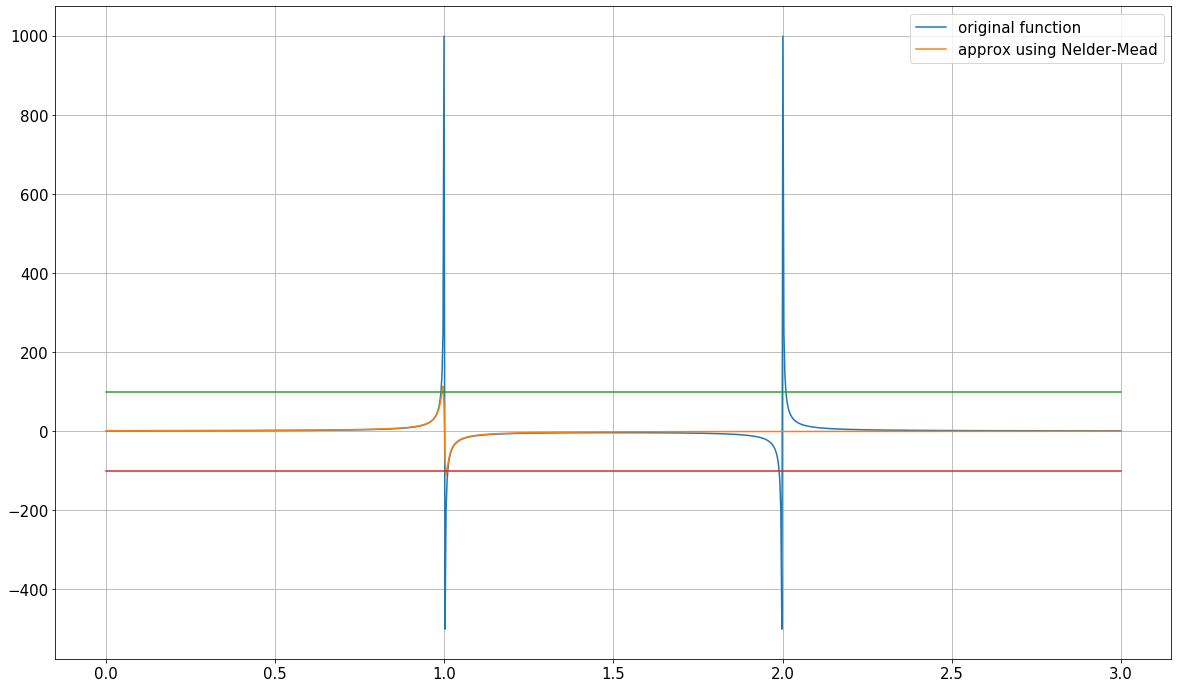

In [219]:
fig, ax = plt.subplots(figsize = (20, 12))

plt.plot(x_arr, initial_func(x_arr))

for i in range(1):
    plt.plot(x_arr, approximant_func(x_arr, df[df.columns[i]][df.index[:-2]]))

plt.plot(x_arr, [100] * len(x_arr))
plt.plot(x_arr, [-100] * len(x_arr))


plt.legend(['original function', 'approx using Nelder-Mead'])
plt.grid()

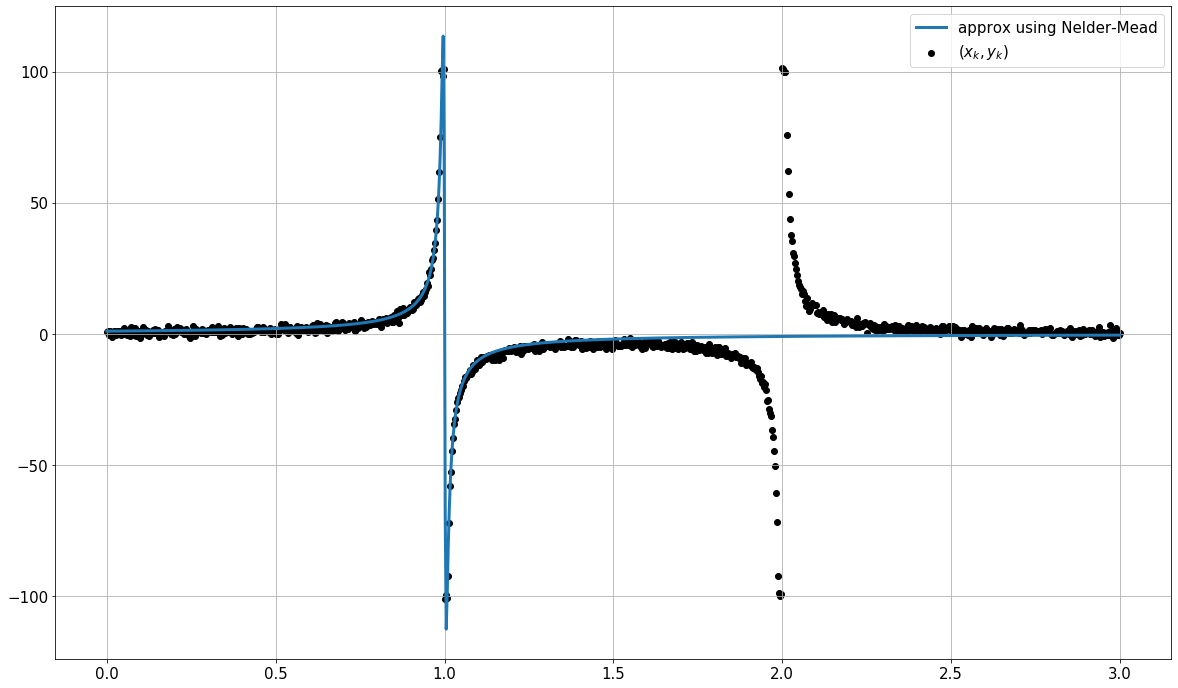

In [230]:
fig, ax = plt.subplots(figsize = (20, 12))

plt.scatter(x_arr, y_arr, c = 'k', label = 'Data')

for i in range(1):
    plt.plot(x_arr, approximant_func(x_arr, df[df.columns[i]][df.index[:-2]]), linewidth = 3)

plt.legend(['approx using Nelder-Mead', '$(x_k, y_k)$'])
plt.grid()